<a href="https://colab.research.google.com/github/YulianaPoliakova/propaganda-detection-ml/blob/main/2023_Project_prop_tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Persuasion Techniques in multilingual Online News

Given the textual content of an article, identify the techniques used in it (multilabel classification problem).

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/huggingface/transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-lyyhc4pi
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-lyyhc4pi
  Resolved https://github.com/huggingface/transformers to commit 8b129030cbce6e5a702dae873e52221d2b35c9fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.29.0.dev0-py3-none-any.whl size=6991794 sha256=7e50b9ca854497b8a7545651ed4108c57e8b54a57108b6d369c5969afbdc291c
  Stored in directory: /tmp/pip-ephem-wheel-cache-053lx4oe/wheels/14/a0/7b/8f6b25ba4110aa215fcb8d6aedd6cd4f9b9b6619190

In [ ]:
! pip install  "datasets" "pytorch-lightning" 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.4 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 13.1 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00


In [ ]:
import os
import sys
import torch
from torch.utils.data import (
    Dataset, TensorDataset,
    DataLoader, RandomSampler,
    SequentialSampler)
import torch.nn as nn
import torchmetrics
import torchmetrics.functional as func

from pytorch_lightning import (
    LightningDataModule, LightningModule, 
    Trainer, seed_everything)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Callback
from transformers import (
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_constant_schedule_with_warmup,
    MMBTConfig,
    MMBTModel,
    VisualBertModel,
    AutoModelForCausalLM
)
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
from transformers import BitsAndBytesConfig

In [ ]:
from torchvision import transforms, models
from torchvision.models import detection
import cv2
from PIL import Image
from tqdm import tqdm
import csv
import gc
import json
import re
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

In [ ]:
from accelerate import init_empty_weights

# Helper functions

In [ ]:
def plot_confusion_matrix(cm, num_classes=15, title='confusion matrix', 
                          classes=['negative', 'positive'], cmap=plt.cm.YlGn):

    title = title

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(num_classes-0.5, -0.5)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def plot_confusion_multi(all_cm, classes):
  assert len(all_cm)==len(classes)
  label =0
  for cm in all_cm:
    class_name=classes[label]
    title="confusion matrix for "+str(class_name)
    plot_confusion_matrix(cm,2,title=title)
    label=label+1

In [ ]:
AVAIL_GPUS = 0
if torch.cuda.is_available():       
    device = torch.device("cuda")
    AVAIL_GPUS = torch.cuda.device_count()
    print(f'There are {AVAIL_GPUS} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
                                                                                                                                                                                                                                            
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [ ]:
def make_dataframe(input_folder, labels_fn=None):
    # MAKE TXT DATAFRAME
    text = []
    for fil in tqdm(filter(lambda x: x.endswith('.txt'), os.listdir(input_folder))):
      if fil[1] == "_":
        fil = fil[2:]
      iD = fil[7:].split('.')[0]
      lines = list(enumerate(open(input_folder +'/' + fil, 'r', encoding='utf-8').read().splitlines(), 1))
      text.extend([(iD,) + line for line in lines])

    df_text = pd.DataFrame(text, columns=['id', 'line', 'text'])
    df_text.id = df_text.id.apply(int)
    df_text.line = df_text.line.apply(int)
    df_text = df_text[df_text.text.str.strip().str.len() > 0].copy()
    df_text = df_text.set_index(['id', 'line'])

    df = df_text

    if labels_fn:
        # MAKE LABEL DATAFRAME
        labels = pd.read_csv(labels_fn, sep='\t', encoding='utf-8', header=None)
        labels = labels.rename(columns={0: 'id', 1: 'line', 2: 'labels'})
        labels = labels.set_index(['id', 'line'])
        labels = labels[labels.labels.notna()].copy()

        # JOIN
        df = labels.join(df_text)[['text', 'labels']]

    return df

#Import Data

## Russian Dataset

In [ ]:
folder_train = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/train-articles-subtask-3'
folder_dev = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/dev-articles-subtask-3'
labels_train_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/train-labels-subtask-3.txt'
labels_dev_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/dev-labels-subtask-3.txt'
out_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/output.txt'

# Read Data
print('Loading dataset...',  make_dataframe(folder_train, labels_train_fn))
train = make_dataframe(folder_train, labels_train_fn)
train_data = train
val_data = make_dataframe(folder_dev, labels_dev_fn)

249it [00:02, 86.23it/s] 


Loading dataset...                                                          text  \
id    line                                                      
241   1     Кургинян: под прикрытием демократии США привод...   
      3     США используют слова о демократии для того, чт...   
      5     «Теперь говорится, что у нас ось зла — авторит...   
      6     Он отметил, что подобные лидеры не гнушались о...   
      8     «Про всех остальных говорили то же самое. Чан ...   
...                                                       ...   
24191 1       Начался развал НАТО: альянс покинул Лихтенштейн   
      3     Всё больше стран стараются дистанцироваться от...   
      5     «Мы небольшая европейская страна, нам чужды ми...   
      7     Как отмечают эксперты, Лихтенштейн может стать...   
      9     «Для простого бюргера важно то, как живёт он и...   

                                                       labels  
id    line                                                     
241   1

249it [00:00, 444.31it/s]
59it [00:21,  2.72it/s]


## English Dataset

In [ ]:
folder_train = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/train-articles-subtask-3'
folder_dev = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/dev-articles-subtask-3'
labels_train_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/train-labels-subtask-3.txt'
labels_dev_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/dev-labels-subtask-3.txt'
out_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/output.txt'

# Read Data
print('Loading dataset...',  make_dataframe(folder_train, labels_train_fn))
train = make_dataframe(folder_train, labels_train_fn)
train_data = train
val_data = make_dataframe(folder_dev, labels_dev_fn)

6it [00:02,  2.63it/s]

## German Dataset

In [ ]:
folder_train = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/train-articles-subtask-3'
folder_dev = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/dev-articles-subtask-3'
labels_train_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/train-labels-subtask-3.txt'
labels_dev_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/dev-labels-subtask-3.txt'
out_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/output.txt'

# Read Data
print('Loading dataset...',  make_dataframe(folder_train, labels_train_fn))
train = make_dataframe(folder_train, labels_train_fn)
train_data = train
val_data = make_dataframe(folder_dev, labels_dev_fn)

132it [00:00, 540.30it/s]


Loading dataset...                                                         text  \
id   line                                                      
221  1     USA verbreiten gefakte Geschichten, um Russlan...   
     3     Die Genies (nicht) im Nationalen Sicherheitsra...   
     5     WASHINGTON – Die Vereinigten Staaten haben Inf...   
2210 3     Wladimir Putin, der Präsident Russlands, ist d...   
     5     Trotz dieser harten Charakterisierungen des ru...   
...                                                      ...   
2299 9     »Man muss davon ausgehen, dass sich der Neubau...   
     15    Die Tageszeitung junge Welt stört die Herrsche...   
     21                Lindners Streichoffertevom 08.07.2022   
     23                  Watschn für A-20-Planvom 08.07.2022   
     25            »Ab Tutzing alles im Arsch«vom 08.07.2022   

                                                      labels  
id   line                                                     
221  1     Loaded_Lang

132it [00:00, 994.90it/s] 
45it [00:00, 788.70it/s]


# PTC: Propaganda Techniques corpus 


## PTC - Training 

### Dataset

In [ ]:
class PTCDataset(Dataset):
    def __init__(self, input_id, attention, labels):
        self.attention = attention
        self.input_id = input_id
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        sample = {"attention_mask": attention,
                  "input_ids": input_id, "labels": label}
        return sample

In [ ]:
train_data = train_data.set_index('text').labels.str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index()
val_data = val_data.set_index('text').labels.str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index()

train_data['label'] = train_data[0]
train_data = train_data.drop(columns=[0])

val_data['label'] = val_data[0]
val_data = val_data.drop(columns=[0])

labels_count = train_data['label'].nunique()

In [ ]:
val_data.describe()

,text,label
count,721,721
unique,310,23
top,"""Киевский режим начал политику террора, блокад...",Loaded_Language
freq,10,185


Overview of the dataset characteristics and of the distribution of the classes.

In [ ]:
train_data

,text,label
0,Кургинян: под прикрытием демократии США привод...,Loaded_Language
1,"США используют слова о демократии для того, чт...",Loaded_Language
2,"США используют слова о демократии для того, чт...",Name_Calling-Labeling
3,"«Теперь говорится, что у нас ось зла — авторит...",Doubt
4,"«Теперь говорится, что у нас ось зла — авторит...",Loaded_Language
...,...,...
4401,"Как отмечают эксперты, Лихтенштейн может стать...",Appeal_to_Values
4402,"Как отмечают эксперты, Лихтенштейн может стать...",Doubt
4403,"Как отмечают эксперты, Лихтенштейн может стать...",Loaded_Language
4404,"Как отмечают эксперты, Лихтенштейн может стать...",Questioning_the_Reputation


In [ ]:
train_data.describe()

,text,label
count,4406,4406
unique,1244,23
top,"«Настоящим врагом Европейского союза, – пишет...",Loaded_Language
freq,16,1112


In [ ]:
frequences = train_data.groupby(['label']).size()
frequences

label
Appeal_to_Authority                   15
Appeal_to_Fear-Prejudice             101
Appeal_to_Hypocrisy                  166
Appeal_to_Popularity                  14
Appeal_to_Time                        52
Appeal_to_Values                      77
Causal_Oversimplification             70
Consequential_Oversimplification     123
Conversation_Killer                  151
Doubt                                878
Exaggeration-Minimisation            223
False_Dilemma-No_Choice               43
Flag_Waving                           69
Guilt_by_Association                  40
Loaded_Language                     1112
Name_Calling-Labeling                429
Obfuscation-Vagueness-Confusion       36
Questioning_the_Reputation           519
Red_Herring                            4
Repetition                           116
Slogans                              122
Straw_Man                             32
Whataboutism                          14
dtype: int64

<Axes: xlabel='label'>

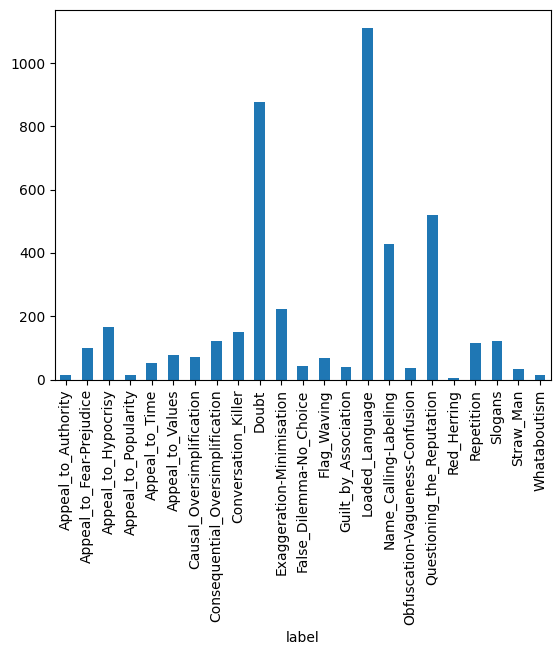

In [ ]:
frequences.plot(kind='bar')

## Enrich dataset

Finding: Russian dataset has no multiple labels, every row has only one label


In [ ]:
train_data.describe()

,text,label
count,3053,3053
unique,1245,23
top,Doch Emmanuel Macron hält sich an die alte Dok...,Name_Calling-Labeling
freq,11,734


<Axes: xlabel='label'>

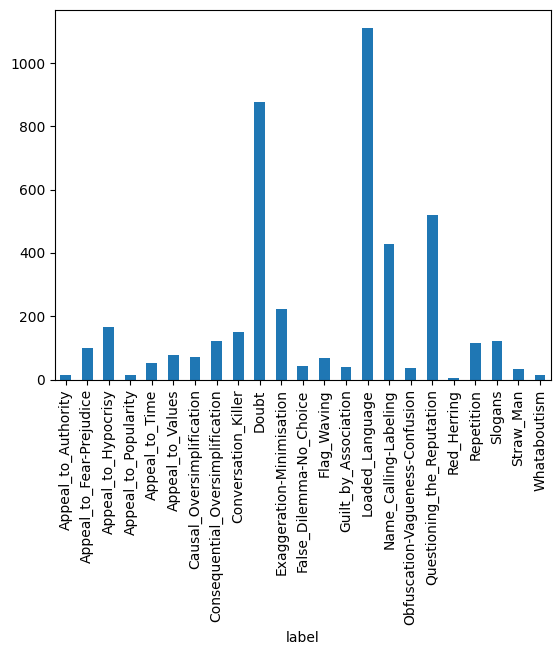

In [ ]:
train_data.describe()
frequences = train_data.groupby(['label']).size()
frequences.plot(kind='bar')

In [ ]:
train_data

,text,label
0,Geneva - The World Health Organisation chief o...,Doubt
1,Geneva - The World Health Organisation chief o...,Doubt
2,"""The next transmission could be more pronounce...",Appeal_to_Authority
3,"""The next transmission could be more pronounce...",Appeal_to_Authority
4,"But Tedros voiced alarm that ""plague in Madaga...",Repetition
...,...,...
5926,We must support our law enforcement and first ...,Flag_Waving
5927,Our country's leaders must always put the need...,Flag_Waving
5928,We must never forget the sacrifices of our fou...,Flag_Waving
5929,Our nation's success is due to the hard work a...,Flag_Waving


In [ ]:
labels_list = list(new_df.groupby('label').filter(lambda x: len(x) < 300)['label'].unique())


In [ ]:
labels_list

['Loaded_Language',
 'Questioning_the_Reputation',
 'Guilt_by_Association',
 'Consequential_Oversimplification',
 'Exaggeration-Minimisation',
 'Obfuscation-Vagueness-Confusion',
 'Conversation_Killer',
 'Appeal_to_Fear-Prejudice',
 'False_Dilemma-No_Choice',
 'Slogans',
 'Doubt',
 'Appeal_to_Popularity',
 'Appeal_to_Values',
 'Causal_Oversimplification',
 'Appeal_to_Authority',
 'Flag_Waving',
 'Appeal_to_Time',
 'Straw_Man',
 'Appeal_to_Hypocrisy',
 'Whataboutism',
 'Red_Herring',
 'Repetition']

In [ ]:
(train_data['label'].str.contains(',', regex=False)).sum()

0

In [ ]:
# Split the labels by comma and create new rows for each label that is in the allowed_labels list
new_rows = []
for index, row in train_data.iterrows():
    labels = row['label'].split(',')
    for label in labels:
        label = label.strip()
        if label in labels_list:
            new_row = {'text': row['text'], 'label': label}
            new_rows.append(new_row)

# Create the new dataframe with the old rows and the new rows
new_df = train_data[train_data['label'].apply(lambda x: not any(l in x.split(',') for l in labels_list))]
new_df = new_df.append(pd.DataFrame(new_rows), ignore_index=True)

# Set the index column
new_df.index.name = 'index'

print(new_df)

                                                    text  \
index                                                      
0      USA verbreiten gefakte Geschichten, um Russlan...   
1      USA verbreiten gefakte Geschichten, um Russlan...   
2      USA verbreiten gefakte Geschichten, um Russlan...   
3      Die Genies (nicht) im Nationalen Sicherheitsra...   
4      Die Genies (nicht) im Nationalen Sicherheitsra...   
...                                                  ...   
3048   Dieser Flirt nimmt bizarre Formen an: Als jetz...   
3049   Dieser Flirt nimmt bizarre Formen an: Als jetz...   
3050   Die Preissteigerungen halten an: Fortwährend h...   
3051   »Man muss davon ausgehen, dass sich der Neubau...   
3052   Die Tageszeitung junge Welt stört die Herrsche...   

                            label  
index                              
0                 Loaded_Language  
1           Name_Calling-Labeling  
2      Questioning_the_Reputation  
3                 Loaded_Language  
4  

In [ ]:

# split the labels column by commas and stack the resulting DataFrame
labels_df = (train_data['label'].str.split(',', expand=True)
             .stack()
             .reset_index(level=1, drop=True)
             .rename('label'))

# drop the original labels column and join with the new labels DataFrame
new_df = train_data.drop('label', axis=1).join(labels_df)

print(new_df)

                                                   text  \
0     Кургинян: под прикрытием демократии США привод...   
1     США используют слова о демократии для того, чт...   
2     США используют слова о демократии для того, чт...   
3     «Теперь говорится, что у нас ось зла — авторит...   
4     «Теперь говорится, что у нас ось зла — авторит...   
...                                                 ...   
4401  Как отмечают эксперты, Лихтенштейн может стать...   
4402  Как отмечают эксперты, Лихтенштейн может стать...   
4403  Как отмечают эксперты, Лихтенштейн может стать...   
4404  Как отмечают эксперты, Лихтенштейн может стать...   
4405  «Для простого бюргера важно то, как живёт он и...   

                                 label  
0                      Loaded_Language  
1                      Loaded_Language  
2                Name_Calling-Labeling  
3                                Doubt  
4                      Loaded_Language  
...                                ...  
4401

In [ ]:
labels_df

0                        Loaded_Language
1                        Loaded_Language
2                  Name_Calling-Labeling
3                                  Doubt
4                        Loaded_Language
                      ...               
4401                    Appeal_to_Values
4402                               Doubt
4403                     Loaded_Language
4404          Questioning_the_Reputation
4405    Consequential_Oversimplification
Name: label, Length: 4406, dtype: object

In [ ]:
rows_to_remove = new_df['label'].str.contains('|'.join(labels_list))

new_df_small = new_df[~rows_to_remove]

In [ ]:
new_df_small.describe()

,text,label
count,1468,1468
unique,623,19
top,"«Настоящим врагом Европейского союза, – пишет...",Exaggeration-Minimisation
freq,10,223


In [ ]:

# filter the labels DataFrame to only include labels in the specified list
labels_df = labels_df[labels_df['label'].isin(labels_list)]

# merge the labels DataFrame with the original DataFrame using the index
new_df = pd.merge(df, labels_df, left_index=True, right_index=True)[['text', 'label']]

# drop the original labels column and join with the new labels DataFrame
new_df = new_df.drop('label', axis=1).merge(labels_df, on='index')

new_df.describe()

Copy entries with multiple labels

In [ ]:
new_df

,text,label
index,,
0,"USA verbreiten gefakte Geschichten, um Russlan...",Loaded_Language
1,"USA verbreiten gefakte Geschichten, um Russlan...",Name_Calling-Labeling
2,"USA verbreiten gefakte Geschichten, um Russlan...",Questioning_the_Reputation
3,Die Genies (nicht) im Nationalen Sicherheitsra...,Loaded_Language
4,Die Genies (nicht) im Nationalen Sicherheitsra...,Name_Calling-Labeling
...,...,...
3048,Dieser Flirt nimmt bizarre Formen an: Als jetz...,Conversation_Killer
3049,Dieser Flirt nimmt bizarre Formen an: Als jetz...,Guilt_by_Association
3050,Die Preissteigerungen halten an: Fortwährend h...,Appeal_to_Hypocrisy


In [ ]:
new_df.describe()

,text,label
count,3053,3053
unique,1245,23
top,Doch Emmanuel Macron hält sich an die alte Dok...,Name_Calling-Labeling
freq,11,734


Splitting by labels and adding multiple labels as copies to df results in extra 200 articles :(

Results for not copying top 4 labels:  

<AxesSubplot:xlabel='label'>

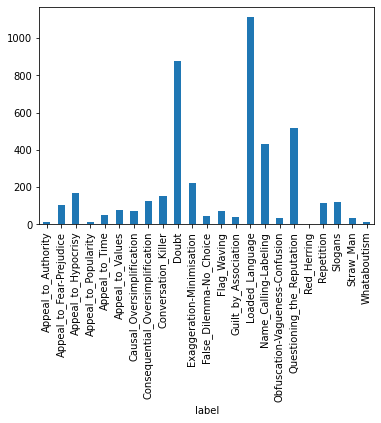

In [ ]:
new_df.describe()
frequences = new_df.groupby(['label']).size()
frequences.plot(kind='bar')

In [ ]:
# save the dataframe as a csv file
train_data.to_csv('/content/drive/MyDrive/semeval2023task3bundle-v3/data/my_dataframe_ru_be.csv', index=False)

## Enrich text by duplicating


In [ ]:
train_data.describe()

,text,label
count,4406,4406
unique,1244,23
top,"«Настоящим врагом Европейского союза, – пишет...",Loaded_Language
freq,16,1112


In [ ]:
train_data

,text,label
0,Кургинян: под прикрытием демократии США привод...,Loaded_Language
1,"США используют слова о демократии для того, чт...",Loaded_Language
2,"США используют слова о демократии для того, чт...",Name_Calling-Labeling
3,"«Теперь говорится, что у нас ось зла — авторит...",Doubt
4,"«Теперь говорится, что у нас ось зла — авторит...",Loaded_Language
...,...,...
4401,"Как отмечают эксперты, Лихтенштейн может стать...",Appeal_to_Values
4402,"Как отмечают эксперты, Лихтенштейн может стать...",Doubt
4403,"Как отмечают эксперты, Лихтенштейн может стать...",Loaded_Language
4404,"Как отмечают эксперты, Лихтенштейн может стать...",Questioning_the_Reputation


In [ ]:
def double_labels(df):
  labels_list = list(df.groupby('label').filter(lambda x: len(x) < 200 and len(x) > 50)['label'].unique())

  # boolean indexing to filter rows with labels_list
  mask = df['label'].isin(labels_list)

  # duplicate rows with labels_list
  duplicated_rows = df[mask].copy()
  duplicated_rows.index = duplicated_rows.index + len(df) # reset index to be unique

  # concat original and duplicated rows
  new_df = pd.concat([df, duplicated_rows])

  # sort index to preserve order
  new_df = new_df.sort_index()

  return new_df

In [ ]:
labels_list = list(train_data.groupby('label').filter(lambda x: len(x) < 400)['label'].unique())

In [ ]:
# boolean indexing to filter rows with labels_list
mask = train_data['label'].isin(labels_list)

# duplicate rows with labels_list
duplicated_rows = train_data[mask].copy()
duplicated_rows.index = duplicated_rows.index + len(train_data) # reset index to be unique

# concat original and duplicated rows
new_df = pd.concat([train_data, duplicated_rows])

# sort index to preserve order
new_df = new_df.sort_index()

print(new_df)

                                                   text  \
0     Кургинян: под прикрытием демократии США привод...   
1     США используют слова о демократии для того, чт...   
2     США используют слова о демократии для того, чт...   
3     «Теперь говорится, что у нас ось зла — авторит...   
4     «Теперь говорится, что у нас ось зла — авторит...   
...                                                 ...   
8802  Всё больше стран стараются дистанцироваться от...   
8803  Всё больше стран стараются дистанцироваться от...   
8806  Как отмечают эксперты, Лихтенштейн может стать...   
8807  Как отмечают эксперты, Лихтенштейн может стать...   
8811  «Для простого бюргера важно то, как живёт он и...   

                                 label  
0                      Loaded_Language  
1                      Loaded_Language  
2                Name_Calling-Labeling  
3                                Doubt  
4                      Loaded_Language  
...                                ...  
8802

In [ ]:
new_df.describe()

,text,label
count,5874,5874
unique,1244,23
top,"«Настоящим врагом Европейского союза, – пишет...",Loaded_Language
freq,26,1112


<Axes: xlabel='label'>

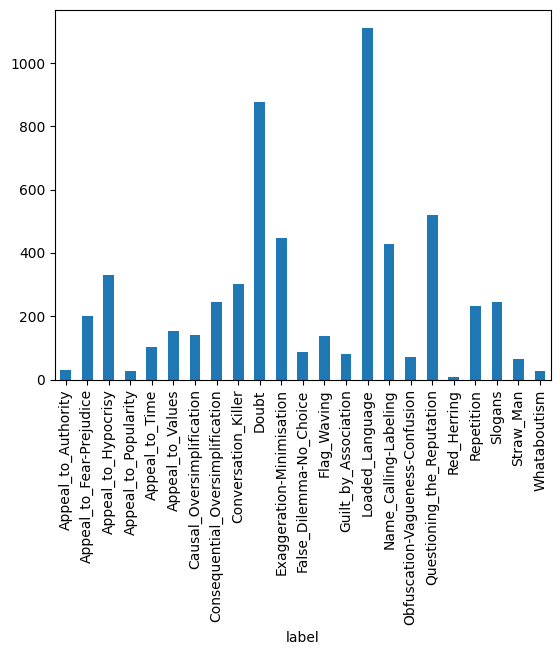

In [ ]:
new_df.describe()
frequences = new_df.groupby(['label']).size()
frequences.plot(kind='bar')

In [ ]:
train_data=new_df

In [ ]:
val_data.describe()

,text,label
count,721,721
unique,310,23
top,"""Киевский режим начал политику террора, блокад...",Loaded_Language
freq,10,185


In [ ]:
new_val = double_labels(val_data)

In [ ]:
new_val.describe()
val_data = new_val

<Axes: xlabel='label'>

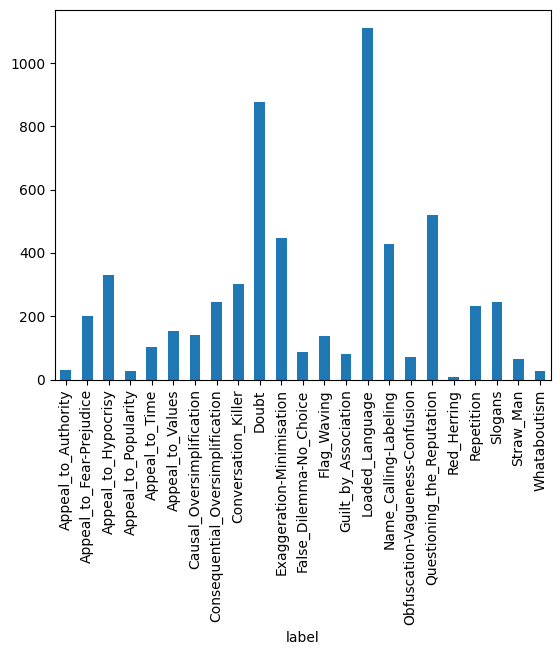

In [ ]:
train_data.describe()
frequences = train_data.groupby(['label']).size()
frequences.plot(kind='bar')

## Filter < 50

In [ ]:
# filter the dataframe to only include labels with frequency < 50
freq_less_than_50 = list(train_data.groupby('label').filter(lambda x: len(x) < 50)['label'].unique())

In [ ]:
freq_less_than_50

['Whataboutism', 'Red_Herring', 'Appeal_to_Authority', 'Appeal_to_Popularity']

In [ ]:
rows_to_remove = train_data['label'].str.contains('|'.join(freq_less_than_50))


train_data_small = train_data[rows_to_remove]
train_data_trimmed = train_data[~rows_to_remove]

rows_to_remove = val_data['label'].str.contains('|'.join(freq_less_than_50))

In [ ]:
train_data = train_data_trimmed
val_data = val_data[~rows_to_remove]

labels_count = train_data['label'].nunique()

In [ ]:
train_data.describe()

,text,label
count,5780,5780
unique,1241,19
top,"«Настоящим врагом Европейского союза, – пишет...",Loaded_Language
freq,26,1112


<Axes: xlabel='label'>

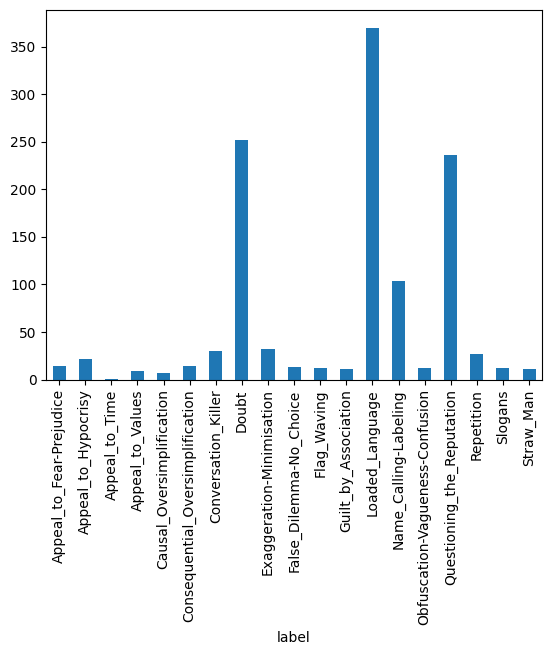

In [ ]:
val_data.describe()
frequences = val_data.groupby(['label']).size()
frequences.plot(kind='bar')

<Axes: xlabel='label'>

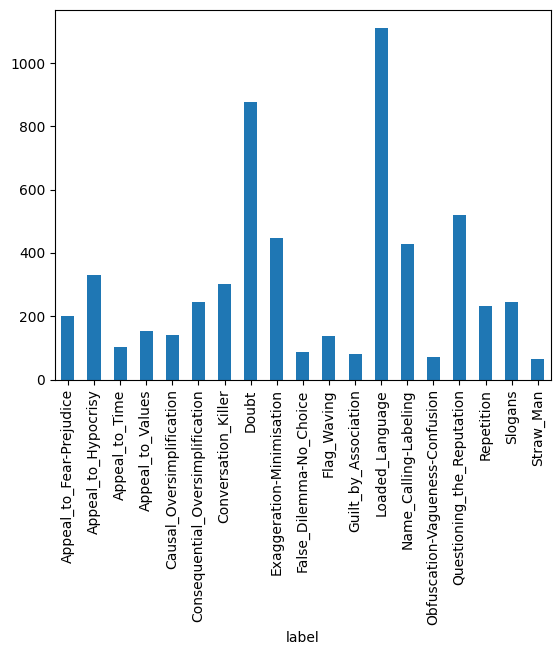

In [ ]:
train_data.describe()
frequences = train_data.groupby(['label']).size()
frequences.plot(kind='bar')

## GPT Dataset

```



### GPT Base English 


In [ ]:
# Read the text file and add the columns to the existing DataFrame
filename = '/content/drive/MyDrive/semeval2023task3bundle-v3/gpt_dataset.txt'
new_data = pd.read_csv(filename, sep='.', names=['text', 'label'], skiprows=[0])

# Remove the comma from the second column
new_data['label'] = new_data['label'].str.replace(",", "")
new_data['label'] = new_data['label'].str.replace("Flag W", "Flag_W")
                       
print(new_data)
train_data = pd.concat([train_data, new_data], ignore_index=True)

# Print the updated DataFrame
#print(df)

                                                 text        label
0   We must support our troops and defend our nati...  Flag_Waving
1   America is the greatest nation on earth, and w...  Flag_Waving
2   Our nation has a proud tradition of liberty an...  Flag_Waving
3   Our country is a shining beacon of hope and fr...  Flag_Waving
4   We must honor the sacrifices of our forefather...  Flag_Waving
..                                                ...          ...
65  We must support our law enforcement and first ...  Flag_Waving
66  Our country's leaders must always put the need...  Flag_Waving
67  We must never forget the sacrifices of our fou...  Flag_Waving
68  Our nation's success is due to the hard work a...  Flag_Waving
69  We must always remember that our country is fo...  Flag_Waving

[70 rows x 2 columns]


### GPT English Topics


In [ ]:
# Read the text file and add the columns to the existing DataFrame
filename = '/content/drive/MyDrive/semeval2023task3bundle-v3/flag_waving_en_gpt.txt'

# Read the data using the first separator
data1 = pd.read_csv(filename, sep=',Fl', names=['text', 'label'], skiprows=[0])

# Read the data using the second separator
data2 = pd.read_csv(filename, sep=',\"Fl', names=['text', 'label'], skiprows=[0])

# Concatenate the two dataframes
new_data = pd.concat([data1, data2])

new_data['text'] = new_data['text'].str.replace('"', "")
new_data['label'] = new_data['label'].str.replace('"', "")
new_data['label'] = new_data['label'].str.replace("ag W", "Flag_W")

new_data = new_data.dropna(subset=['label'])

print(new_data)

In [ ]:
new_data.to_csv('/content/drive/MyDrive/semeval2023task3bundle-v3/data/gpt_dataframe_ge.csv', index=False)

In [ ]:
train_data = pd.concat([train_data, new_data], ignore_index=True)

### GPT Russian Topics


In [ ]:
# Read the text file and add the columns to the existing DataFrame
filename = '/content/drive/MyDrive/semeval2023task3bundle-v3/slogans_ru_gpt.txt'

# Read the data using the first separator
data1 = pd.read_csv(filename, sep=',Sl', names=['text', 'label'], skiprows=[0])

# Read the data using the second separator
data2 = pd.read_csv(filename, sep=',\"Sl', names=['text', 'label'], skiprows=[0])

# Concatenate the two dataframes
new_data = pd.concat([data1, data2])

new_data = new_data.dropna(subset=['label'])
new_data['text'] = new_data['text'].str.replace('"', "")
new_data['label'] = new_data['label'].str.replace('"', "")
new_data['label'] = new_data['label'].str.replace("ogans", "Slogans")

print(new_data)

<ipython-input-41-87c8c0ec21ec>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data1 = pd.read_csv(filename, sep=',Sl', names=['text', 'label'], skiprows=[0])


                                                 text    label
0   Американская политика против России - это анти...  Slogans
1   Москва призывает к диалогу, однако нашим амери...  Slogans
2    Давайте вместе бороться с американской агрессией  Slogans
3        США настаивают на своем доминировании в мире  Slogans
4     США хотят ослабить роль России на мировой арене  Slogans
..                                                ...      ...
95      НАТО - это главный враг России и мира в целом  Slogans
96  Россия защищает суверенитет и независимость от...  Slogans
97  НАТО - это противник России в вопросах междуна...  Slogans
98  Россия является главным гарантом мира и безопа...  Slogans
99  НАТО - это враг России, который не остановится...  Slogans

[120 rows x 2 columns]


<ipython-input-41-87c8c0ec21ec>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data2 = pd.read_csv(filename, sep=',\"Sl', names=['text', 'label'], skiprows=[0])


In [ ]:
train_data = pd.concat([train_data, new_data], ignore_index=True)

### GPT German Topics

In [ ]:
# Read the text file and add the columns to the existing DataFrame
filename = '/content/drive/MyDrive/semeval2023task3bundle-v3/loaded_language_ge_gpt.txt'

# Read the data using the first separator
data1 = pd.read_csv(filename, sep=',Loa', names=['text', 'label'], skiprows=[0])

# Read the data using the second separator
data2 = pd.read_csv(filename, sep=',\"Loa', names=['text', 'label'], skiprows=[0])

# Read the data using the second separator
data3 = pd.read_csv(filename, sep='\",1', names=['text', 'label'], skiprows=[0])

data3.loc[:, 'label'] = 'Loaded_Language'

# Concatenate the two dataframes
new_data = pd.concat([data1, data2])
new_data = pd.concat([new_data, data3])

new_data = new_data.dropna(subset=['label'])
new_data['text'] = new_data['text'].str.replace('"', "")
new_data['label'] = new_data['label'].str.replace('"', "")
new_data['label'] = new_data['label'].str.replace("ded l", "Loaded_L")

print(new_data)

                                                 text            label
0   Das Corona-Virus tötet immer mehr Menschen in ...  Loaded_Language
1   Die Inzidenzen schnellen in die Höhe, die Zahl...  Loaded_Language
2   Die dritte Welle rollt an und droht, das Gesun...  Loaded_Language
3   Die Pandemie frisst sich weiter durch die Bevö...  Loaded_Language
4   Die Regierung reagiert zu langsam und unentsch...  Loaded_Language
..                                                ...              ...
95  Die syrische Regierung unter Assad ist ein Dik...  Loaded_Language
96  Der Krieg in Syrien hat verheerende Auswirkung...  Loaded_Language
97  Die syrische Regierung missachtet die Rechte i...  Loaded_Language
98  Die syrische Opposition kämpft für Freiheit un...  Loaded_Language
99  Assad und seine Verbündeten setzen gezielt auf...  Loaded_Language

[160 rows x 2 columns]


<ipython-input-29-5dd89f26d835>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data1 = pd.read_csv(filename, sep=',Loa', names=['text', 'label'], skiprows=[0])
<ipython-input-29-5dd89f26d835>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data2 = pd.read_csv(filename, sep=',\"Loa', names=['text', 'label'], skiprows=[0])
<ipython-input-29-5dd89f26d835>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data3 =

In [ ]:
train_data = pd.concat([train_data, new_data], ignore_index=True)


## Shuffle the dataset

In [ ]:
# Set a random seed for reproducibility
np.random.seed(88)

# Shuffle the rows randomly
train_data = train_data.sample(frac=1).reset_index(drop=True)

## Pre-trained Transformer Name

This section is used to choose which pre-trained model to load from HuggingFace library.

In [ ]:
#pretrained_transformer_name = "microsoft/mdeberta-v3-base"
#pretrained_transformer_name = "xlm-roberta-base" # try large, base is 17.7 GB
#pretrained_transformer_name = "xlm-roberta-large"
#pretrained_transformer_name = "facebook/mbart-large-50" nah
#pretrained_transformer_name = "facebook/xglm-564M" out of memory
#pretrained_transformer_name = "google/flan-t5-base" #multilngual

#pretrained_transformer_name = "microsoft/deberta-base"
#pretrained_transformer_name = "albert-base-v2"
#pretrained_transformer_name = "roberta-base"
#pretrained_transformer_name = "roberta-large"
#pretrained_transformer_name = "j-hartmann/emotion-english-distilroberta-base"
#pretrained_transformer_name = "bhadresh-savani/distilbert-base-uncased-emotion"

#pretrained_transformer_name = "DeepPavlov/rubert-base-cased"
pretrained_transformer_name = "ai-forever/ruBert-base" 
#pretrained_transformer_name = "sberbank-ai/ruT5-base"
#pretrained_transformer_name = "cointegrated/rubert-tiny-toxicity"
#pretrained_transformer_name = "ai-forever/sbert_large_mt_nlu_ru"

#pretrained_transformer_name = "ml6team/distilbert-base-german-cased-toxic-comments"
#pretrained_transformer_name = "oliverguhr/german-sentiment-bert"

checkpoint_name= pretrained_transformer_name.replace("/","_")

## NeptuneAI

In [ ]:
!pip install neptune-client torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.7 MB/s eta 0:00:00


In [ ]:
!pip install neptune-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neptune-contrib: filename=neptune_contrib-0.28.1-py3-none-any.whl size=88348 sha256=9f951f4d94de26b8273d324ea83a6b405f6fd4cfbca49e1ee9413f617378dd49
  Stored in directory: /root/.cache/pip/wheels/94/eb/a9/40139e745d5ceab3179b8816fde8591189e1e8db14853296b7
Successfully built neptune-contrib


In [ ]:
import neptune.new as neptune
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve

/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-47-4fb45f9b21e5>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [ ]:
run = neptune.init_run(
    project="yuliana.poliakova/ba-thesis-experiments",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyZGY1OTMzMS05NjBkLTQzYmItODMwMy1mMTJkODllNjQzZTYifQ==",
)

params = {
    "bs": 16,
    "num_epoch": 1,
    "n_classes": labels_count,
    "learning_rate": 2e-5,
    "adam_epsilon" : 1e-8,
    "model_name": pretrained_transformer_name
}
run["parameters"] = params

#run = neptune.init_run(source_files=["BA_Project.ipynb"]) 


<ipython-input-48-2d356921b0b3>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/yuliana.poliakova/ba-thesis-experiments/e/BAT-145


## 8 Bit Model

In [ ]:
!pip install --quiet bitsandbytes
!pip install --quiet --upgrade transformers # Install latest version of transformers
!pip install --quiet --upgrade accelerate
!pip install --quiet sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 20.1 MB/s eta 0:00:00


In [ ]:
!pip install --quiet transformers bitsandbytes accelerate

In [ ]:
model_name = "t5-3b-sharded"

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# T5-3b and T5-11B are supported!
# We need sharded weights otherwise we get CPU OOM errors
model_id=f"ybelkada/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_8bit = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto", load_in_8bit=True)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.9/dist-packages/cv2/../../lib64')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--listen_host=172.28.0.12 --targe

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Define LightningDataModule

In [ ]:
class PTCDataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        val_data,
        model_name: str = "microsoft/mdeberta-v3-base",
        batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.num_labels = labels_count
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.le = preprocessing.LabelEncoder()
        #self.validation_step_outputs

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.le.fit(self.train_data.label.values)
        y_train = self.le.transform(self.train_data.label.values)

        self.X_val = self.val_data.text.values
        y_val = self.le.transform(self.val_data.label.values)

        #self.max_length = self.maxLen()
        self.max_length = 512

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(
            self.X_val)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = PTCDataset(self.X_train_enc,
                          self.X_train_attention, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size, num_workers = 4)
        return train_dataloader

    def val_dataloader(self):
        data = PTCDataset(self.X_val_enc, self.X_val_attention, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size, num_workers = 4)
        return val_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            encoded_sent = self.tokenizer.encode_plus(
                text=sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        return input_ids, attention_masks

    def maxLen(self):
        X_all = np.concatenate([self.X_train, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len


TODO: Here is where max length should be accepted

##Evaluation


Class that implements the callback that prints the metrics that are used to evaluate a model.

In [ ]:
class PTCEvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.detach().cpu().numpy().astype(int)
        all_labels = model.labels.detach().cpu().numpy().astype(int)

        classes = model.le.classes_

        #neptune.log_image('predictions', all_predictions)
        #neptune.log_image('labels', all_labels)

        run["F1-micro"].append(f1_score(all_labels,
              all_predictions, average='micro', zero_division=1))
        run["F1-macro"].append(f1_score(all_labels,
              all_predictions, average='macro', zero_division=1))

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average='micro', zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average='macro', zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(model.num_classes)], target_names=classes))

        conf_mat = confusion_matrix(all_labels, all_predictions)
        plot_confusion_matrix(conf_mat, classes=classes)

        return


In [ ]:
class CLSExtractor(nn.Module):
    def __init__(self, name):
        super(CLSExtractor, self).__init__()
        self.isCLSLast = (True if name == 'xlnet-base-cased' else False)

    def forward(self, x):
        if(self.isCLSLast):
            return x[0][:, -1, :]
        else:
            return x[0][:, 0, :]

In [ ]:
import gc

In [ ]:
class WeightedCELoss(nn.Module):
    def __init__(self, y_train):
        super(WeightedCELoss, self).__init__()
        self.y_train = y_train
        self.weight = self.weighted_factors()
        self.loss = torch.nn.CrossEntropyLoss(
            weight=self.weight, reduction='mean')

    def forward(self, logits, labels):
        return self.loss(logits, labels)

    def weighted_factors(self):
        f = torch.bincount(self.y_train)
        N = len(self.y_train)
        K = torch.full(size=f.size(), fill_value=N)
        weight = torch.div(torch.sub(K, f), f).to(device=device)
        return weight

In [ ]:
class PTCTransformer(LightningModule):
    def __init__(
        self,
        le,
        y_train=None,
        num_classes: int = labels_count,
        model_name_or_path: str = "microsoft/mdeberta-v3-base",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        batch_size: int = 32,        
        **kwargs,
    ):
        super().__init__()

        self.num_classes = num_classes

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon

        self.save_hyperparameters()

        self.le = le

        self.loss = nn.CrossEntropyLoss()
        #self.loss = FocalLoss()
        #self.loss = WeightedCELoss(y_train)
        self.acc = torchmetrics.Accuracy(task='multiclass', num_classes=23)

        self.labels = torch.Tensor(device=self.device)
        self.predictions = torch.Tensor(device=self.device)
        self.validation_step_outputs = []

        D_in, H, D_out = 768, 96, num_classes
        #D_in, H, D_out = 1024, 96, num_classes 
        #(16x1024 and 768x96)
        self.transformer = AutoModel.from_pretrained(model_name_or_path)
        #self.transformer = model_8bit

        # Load 8-bit with threshold 
        #config = AutoConfig.from_pretrained(model_name_or_path)

        #with init_empty_weights():
         #   model = AutoModelForCausalLM.from_config(config)

        #quantization_config = BitsAndBytesConfig(
         #   llm_int8_threshold=10.0,
        #)

        #self.transformer = AutoModelForCausalLM.from_pretrained(
         #   model_name_or_path,
          #  quantization_config=quantization_config,
        #)
        # end here 
        self.extractor = CLSExtractor(model_name_or_path)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        plm_output = self.transformer(input_ids=inputs["input_ids"],
                                      attention_mask=inputs["attention_mask"])

        last_hidden_state_cls = self.extractor(plm_output)

        logits = self.classifier(last_hidden_state_cls)
        
        # Try to add preictions threshold here
        probs = torch.softmax(logits, dim=1)
        #predictions = (probs >= 0.3).long().float()

        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels)
        predictions = torch.argmax(torch.softmax(logits, dim=1), axis=1)
        acc = self.acc(predictions, labels)
        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels)
        predictions = torch.argmax(logits, axis=1)
        acc = self.acc(predictions, labels)

        #print(f"loss: {val_loss}")

        self.validation_step_outputs.append({"loss": val_loss, "accuracy": acc, 
                "predictions": predictions, "labels": labels}) #on_validation 

        return {"loss": val_loss, "accuracy": acc, 
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
      self.validation_step_outputs.append(outputs)
      return self.validation_step_outputs
        #return outputs
    
    def on_validation_epoch_end(self):
      if(self.current_epoch == self.trainer.max_epochs - 1):
            # Make sure all labels tensors have at least one dimension
            #labels = [label.unsqueeze(0) if label.dim() == 0 else label for label in labels]
    
            #self.labels = torch.stack(labels)
            labels = [x["labels"] for x in self.validation_step_outputs]
            #print(f'Labels: {labels}')
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in self.validation_step_outputs]
            self.predictions = torch.cat(predictions, dim=0)
            #self.predictions = torch.stack(predictions).squeeze()
            #torch.cuda.empty_cache()
            self.validation_step_outputs.clear()  # free memory

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(),
                          lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer


In [ ]:
def validation_epoch_1end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)
            torch.cuda.empty_cache()


##Training 


In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
seed_everything(21)
dm = PTCDataModule(train_data, val_data,
                   model_name=pretrained_transformer_name, batch_size=16)
dm.setup()

INFO:lightning_fabric.utilities.seed:Global seed set to 21


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = PTCTransformer(
    dm.le, dm.y_train, model_name_or_path=pretrained_transformer_name)

Some weights of the model checkpoint at ai-forever/ruBert-base were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer = Trainer(max_epochs=10, logger=None, callbacks=[
                  PTCEvaluateCallback()])  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Fit end: Evaluation....
F1-micro: 0.2648884415366549
F1-macro: 0.08912502564395736
                                  precision    recall  f1-score   support

        Appeal_to_Fear-Prejudice       0.05      0.03      0.04       140
             Appeal_to_Hypocrisy       0.09      0.00      0.01       223
                  Appeal_to_Time       0.00      0.00      0.00        10
                Appeal_to_Values       0.04      0.10      0.06        90
       Causal_Oversimplification       0.00      0.00      0.00        70
Consequential_Oversimplification       0.07      0.31      0.11       140
             Conversation_Killer       0.06      0.13      0.09       300
                           Doubt       0.26      0.50      0.35      2522
       Exaggeration-Minimisation       0.17      0.11      0.13       322
         False_Dilemma-No_Choice       0.00      0.00      0.00       130
                     Flag_Waving       0.03      0.04      0.04       120
            Guilt_by_Associa

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


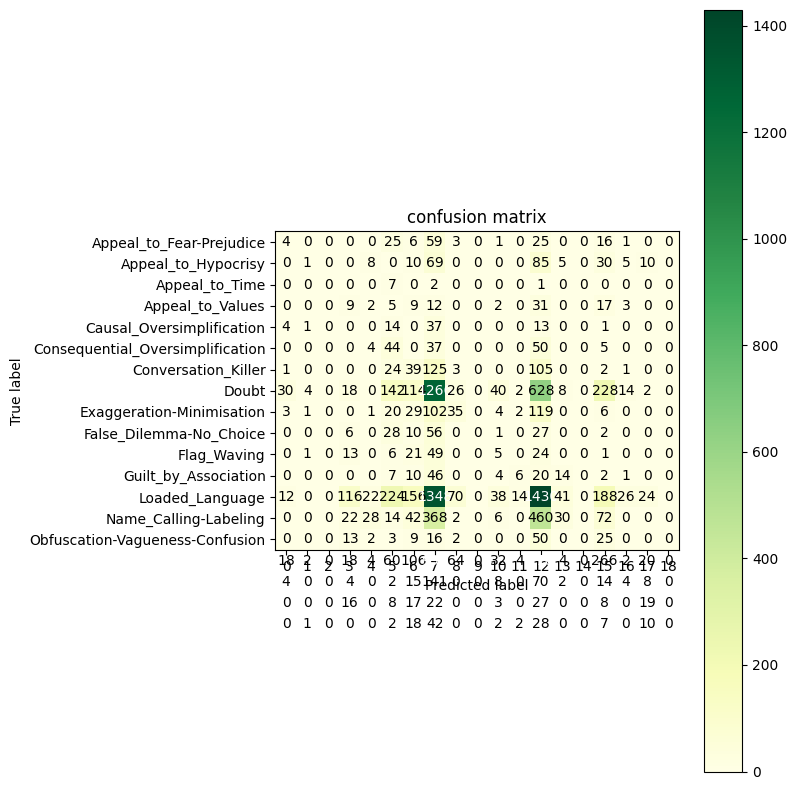

In [ ]:
trainer.fit(model, dm)

#run.stop()

In [ ]:
trainer.save_checkpoint("PTC_"+pretrained_transformer_name+"_FL.ckpt")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
run.stop() 

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuliana.poliakova/ba-thesis-experiments/e/BAT-145/metadata
